In [4]:
import numpy as np
import itertools

In [5]:
def QuadProgWithEquality(Q,c,M,d,K):
  #K : subset des indices des contraintes qui doivent être serrées
  n = Q.shape[0]
  m = M.shape[0]
  k = len(K)

  A = np.block([[ Q , M[K,:].T ] , [M[K,:], np.zeros((k,k))]])
  b = np.concatenate([c,d[K]])

  if np.linalg.det(A) != 0:
    ans = np.linalg.solve(A,b)
    x = ans[:n]
    y = np.zeros(m)
    y[K] = ans[n:]
    return True, x, y
  else:
    return False, [], []

In [6]:
#Paramètres du problème

Q = np.array([[1,0],[0,2]])
c = np.array([3,4])
A = np.array([[-2,1],[1,1],[0,-1]])
b = np.array([0,4,0])

m = len(b) #nb de contraintes

#Solution avec toutes les contraintes serrées
K = [0,1,2]
print(QuadProgWithEquality(Q,c,A,b,K))

#Tester les 2^m possibilités et on appelle la fonction QuadProg pour résoudre les sous-problèmes
for k in range(m+1):
  for subset in itertools.combinations(range(m), k):
    K = list(subset)
    if len(K) != 0:
      flag, x, y = QuadProgWithEquality(Q,c,A,b,K)
      print(flag, x, y)

#La solution 2 est optimale car seule ou les y sont positif => condition KKT vérifiées => il existe 1 seule solution optimale

(False, [], [])
True [1.22222222 2.44444444] [-0.88888889  0.          0.        ]
True [2.33333333 1.66666667] [0.         0.66666667 0.        ]
True [3. 0.] [ 0.  0. -4.]
True [1.33333333 2.66666667] [-1.         -0.33333333  0.        ]
True [-2.22044605e-16 -4.44089210e-16] [-1.5  0.  -5.5]
True [4. 0.] [ 0. -1. -5.]
False [] []


In [7]:
import numpy as np
!pip install gurobipy
import gurobipy as gp
GRB = gp.GRB
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 105.4 MB/s eta 0:00:00


Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 243 rows, 90 columns and 558 nonzeros
Model fingerprint: 0x20c665d4
Variable types: 0 continuous, 90 integer (90 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [4e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 291.6752266
Presolve removed 207 rows and 45 columns
Presolve time: 0.00s
Presolved: 36 rows, 45 columns, 108 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)
Found heuristic solution: objective 152.8291812

Root relaxation: objective -2.916752e+02, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Object

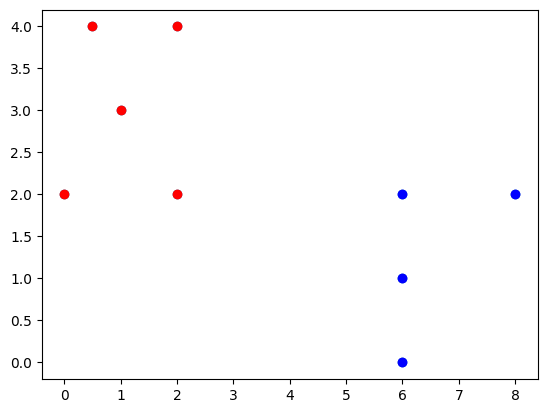

In [8]:
# PROBLEME : Cluster analysis
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

D = np.array([[0,2],
              [2,4],
              [0.5,4],
              [2,2],
              [1,3],
              [6,0],
              [6,2],
              [6,1],
              [8,2]])

plt.plot(D[:,0], D[:,1], 'o')

# Calcul de la matrice des distances
n = D.shape[0]
d = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        d[i, j] = np.linalg.norm(D[i, :] - D[j, :])

# Modèle et Variables
model = gp.Model()
x = model.addMVar((n,), vtype=GRB.BINARY)
p = model.addMVar((n, n), vtype=GRB.BINARY)  # p[i,j] = x[i]*x[j]

# Contraintes pour la linéarisation
for i in range(n):
    for j in range(n):
        model.addConstr(p[i, j] <= x[i])
        model.addConstr(p[i, j] <= x[j])
        model.addConstr(p[i, j] >= x[i] + x[j] - 1)

# Objectif
objectif = 0
for i in range(n):
    for j in range(n):
        objectif += d[i, j] * (4 * p[i, j] - 2 * x[i] - 2 * x[j] + 1)
model.setObjective(objectif, GRB.MINIMIZE)

# Résolution
model.optimize()

# Affichage
print(x.X)

for k in range(n):
  if x[k].X == 1:
    plt.plot(D[k, 0], D[k, 1], 'ob')
  else:
    plt.plot(D[k, 0], D[k, 1], 'or')


In [9]:
# PROBLEME : Implantation d'ateliers

f = np.array([  [0,50,80,0,0,0],
                [0,0,20,50,10,0],
                [20,10,0,20,0,80],
                [0,0,0,0,50,0],
                [0,0,0,0,0,0],
                [20,0,20,0,0,0]])

d = np.array([  [0,2,3,2,2,2],
                [1,0,1,1,1,1],
                [2,1,0,2,1,1],
                [1,1,2,0,1,2],
                [1,1,1,1,0,1],
                [2,1,1,2,1,0]])

n = len(d[0])

#Modèle et Variables
model = gp.Model()
x = model.addMVar((n,n), vtype=GRB.BINARY)
#p = model.addMVar((n,n,n,n), vtype=GRB.BINARY) #pour la linéarisation

#Contraintes de linéarisation
# for i in range(n):
#   for j in range(n):
#     for k in range(n):
#       for l in range(n):
#         model.addConstr(p[i,j,k,l] <= x[i,j])
#         model.addConstr(p[i,j,k,l] <= x[k,l])
#         model.addConstr(p[i,j,k,l] >= x[i,j]+x[k,1]-1)

#Contraintes d'assignement
for i in range(n):
  model.addConstr(sum(x[i,:]) == 1)
for j in range(n):
  model.addConstr(sum(x[:,j]) == 1)

#Objectif
objectif = 0
for i in range(n):
  for j in range(n):
    for k in range(n):
      for l in range(n):
        objectif += f[i,j]*d[k,l]*x[i,k]*x[j,l] #p[i,j,k,l]
model.setObjective(objectif, GRB.MINIMIZE)

#Résolution
model.optimize()

#Affichage
print(x.X)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 12 rows, 36 columns and 72 nonzeros
Model fingerprint: 0x52ac48a0
Model has 270 quadratic objective terms
Variable types: 0 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+01, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 690.0000000
Presolve time: 0.01s
Presolved: 282 rows, 306 columns, 882 nonzeros
Variable types: 0 continuous, 306 integer (306 binary)

Root relaxation: objective 0.000000e+00, 30 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

In [10]:
# PROBLEME : Factorisation matricielle
#résolution du pb :
# min (W, h) ||X-wh^T||_F^2

def MFrank1(X):
  m, n = X.shape

  #Modèle et Variables
  model = gp.Model()
  model.setParam("NonConvex", 2) #autorise les termes bilinéaires (xi*xj) non-convexes
  w = model.addMVar((m,), vtype=GRB.CONTINUOUS)
  h = model.addMVar((n,), vtype=GRB.CONTINUOUS)
  Y = model.addMVar((m,n), vtype=GRB.CONTINUOUS)

  #Contraintes
  for i in range(m):
    for j in range(n):
      model.addConstr(Y[i,j] == w[i]*h[j]) # ok ? Oui car la contrainte est quadratique

  #Objectif
  objectif = 0
  for i in range(m):
    for j in range(n):
      objectif += (X[i,j] - Y[i,j])**2
  model.setObjective(objectif, GRB.MINIMIZE)

  #Résolution
  model.optimize()

  #Affichage
  print(w.X)
  print(h.X)

  return w.X, h.X


In [13]:
import numpy as np

X = np.array([[2,1,0],
              [0,1,3],
              [3,-1,2],
              [0,0,-1]])

# Décomposition SVD
U, S, VT = np.linalg.svd(X, full_matrices=False)

# Approximation rang 1
sigma1 = S[0]
u1 = U[:, 0]
v1 = VT[0, :]

# Vecteurs optimaux w et h tels que X ≈ w @ h.T
w_svd = sigma1 * u1
h_svd = v1

print("w (optimal SVD):")
print(w_svd)

print("h (optimal SVD):")
print(h_svd)

print("Reconstruction X_hat = w @ h.T:")
print(np.outer(w_svd, h_svd))

print("Erreur ||X - X_hat||_F^2:")
print(np.linalg.norm(X - np.outer(w_svd, h_svd))**2)


w (optimal SVD):
[-1.35718302 -2.21208244 -3.49911675  0.73616298]
h (optimal SVD):
[-0.67679476 -0.0035935  -0.73616298]
Reconstruction X_hat = w @ h.T:
[[ 0.91853436  0.00487704  0.9991079 ]
 [ 1.49712581  0.00794911  1.62845321]
 [ 2.36818389  0.01257407  2.57592022]
 [-0.49823125 -0.0026454  -0.54193594]]
Erreur ||X - X_hat||_F^2:
10.478991509260322


In [11]:
import numpy as np

X = np.array([[2,1,0], [0,1,3], [3,-1,2], [0,0,-1]])

wopt, hopt = MFrank1(X)

print(wopt)
print(hopt)

Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
NonConvex  2

Optimize a model with 0 rows, 19 columns and 0 nonzeros
Model fingerprint: 0xe20e8442
Model has 12 quadratic objective terms
Model has 12 quadratic constraints
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e+00, 6e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective 30.0000000
Presolve time: 0.00s
Presolved: 48 rows, 20 columns, 84 nonzeros
Presolved model has 12 quadratic objective terms
Presolved model has 12 bilinear constraint(s)
         i

KeyboardInterrupt: 

In [17]:
#pour x positif
X = np.array([[2,1,0],
              [0,1,3],
              [3,1,2],
              [0,0,-1]])

# Décomposition SVD
U, S, VT = np.linalg.svd(X, full_matrices=False)

# Approximation rang 1
sigma1 = S[0]
u1 = U[:, 0]
v1 = VT[0, :]

# Vecteurs optimaux w et h tels que X ≈ w @ h.T
w_svd = sigma1 * u1
h_svd = v1

print("w (optimal SVD):")
print(w_svd)

print("h (optimal SVD):")
print(h_svd)

print("Reconstruction X_hat = w @ h.T:")
print(np.outer(w_svd, h_svd))

print("Erreur ||X - X_hat||_F^2:")
print(np.linalg.norm(X - np.outer(w_svd, h_svd))**2)

w (optimal SVD):
[-1.62702737 -2.40321144 -3.63841263  0.68556494]
h (optimal SVD):
[-0.64025538 -0.34651661 -0.68556494]
Reconstruction X_hat = w @ h.T:
[[ 1.04171302  0.56379202  1.11543292]
 [ 1.53866904  0.83275269  1.64755751]
 [ 2.32951324  1.26077043  2.49436814]
 [-0.43893664 -0.23755964 -0.46999929]]
Erreur ||X - X_hat||_F^2:
7.869310997637776
